In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,classification_report

2024-11-21 12:48:51.080226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 12:48:51.089949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732189731.100005 3058333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732189731.103156 3058333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 12:48:51.115477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Store Data into DataFrame

In [2]:
data_dir = '../../crop'

filepaths = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        

data_dir = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
data_dir


,filepaths,labels
0,../../crop/C130/c36193479efb089c872ebc488735e9...,C130
1,../../crop/C130/4da597de74ae15f5a304ee93ce4479...,C130
2,../../crop/C130/bcd764fd0fc0f8a548a9cea24e6ac9...,C130
3,../../crop/C130/690c6363f358899eb59efb0ee9ac0a...,C130
4,../../crop/C130/db1e871b3b98ea81975b7a45994fba...,C130
...,...,...
31912,../../crop/KJ600/871e9620c79f258b1364e1ebde2a9...,KJ600
31913,../../crop/KJ600/02d4e0ff5e7864c498c93d71c37d0...,KJ600
31914,../../crop/KJ600/09a85129442d1fa21bbd8771d12ca...,KJ600
31915,../../crop/KJ600/82e61e7df899a6ede16cc977e3161...,KJ600


## Splitting

In [3]:
train_df, dummy_df = train_test_split(data_dir, test_size=0.2, shuffle=True, random_state=42)
val_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)

# Model Structure

In [4]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2]
)
test_gen = ImageDataGenerator()


train_gen = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                      color_mode='rgb', class_mode='categorical', batch_size=16)

val_gen = test_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   color_mode='rgb', class_mode='categorical', batch_size=16)

Found 25533 validated image filenames belonging to 74 classes.
Found 3192 validated image filenames belonging to 74 classes.
Found 3192 validated image filenames belonging to 74 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential

# Load EfficientNetB3 as base model
base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max"
)

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(),
    
    # Add a Dense layer with Batch Normalization and Dropout
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    
    Dense(74, activation='softmax')  # 74 classes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 74)             │        19,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,098,922 (450.51 MB)

 Trainable params: 117,583,786 (448.55 MB)

 Non-trainable params: 515,136 (1.97 MB)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
checkpoint = ModelCheckpoint('best_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * 0.9

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    )

# CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log', append=True)

callbacks = [checkpoint, early_stopping, reduce_lr, lr_scheduler, tensorboard, csv_logger]

In [30]:
history=model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50


2024-11-15 17:46:10.200584: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:46:10.318996: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:46:10.521537: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1731689172.855946  102036 gpu_timer.cc:82] 

 951/1596 ━━━━━━━━━━━━━━━━━━━━ 3:35 335ms/step - accuracy: 0.1187 - loss: 7.3328

2024-11-15 17:52:55.540550: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:52:55.652361: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-15 17:52:55.840578: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1731689577.890332  102036 gpu_timer.cc:82] 

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.1746 - loss: 6.6009
Epoch 1: val_accuracy improved from -inf to 0.59492, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 845s 425ms/step - accuracy: 0.1747 - loss: 6.5999 - val_accuracy: 0.5949 - val_loss: 2.4633 - learning_rate: 0.0010
Epoch 2/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5736 - loss: 2.3657
Epoch 2: val_accuracy improved from 0.59492 to 0.70833, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 582s 364ms/step - accuracy: 0.5736 - loss: 2.3656 - val_accuracy: 0.7083 - val_loss: 1.4937 - learning_rate: 0.0010
Epoch 3/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6936 - loss: 1.5042
Epoch 3: val_accuracy improved from 0.70833 to 0.78289, saving model to best_model.keras
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 580s 363ms/step - accuracy: 0.6936 - loss: 1.5041 - val_accuracy: 0.7829 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 4/50
1596/1596 ━━━━━━━━━━━━━━━

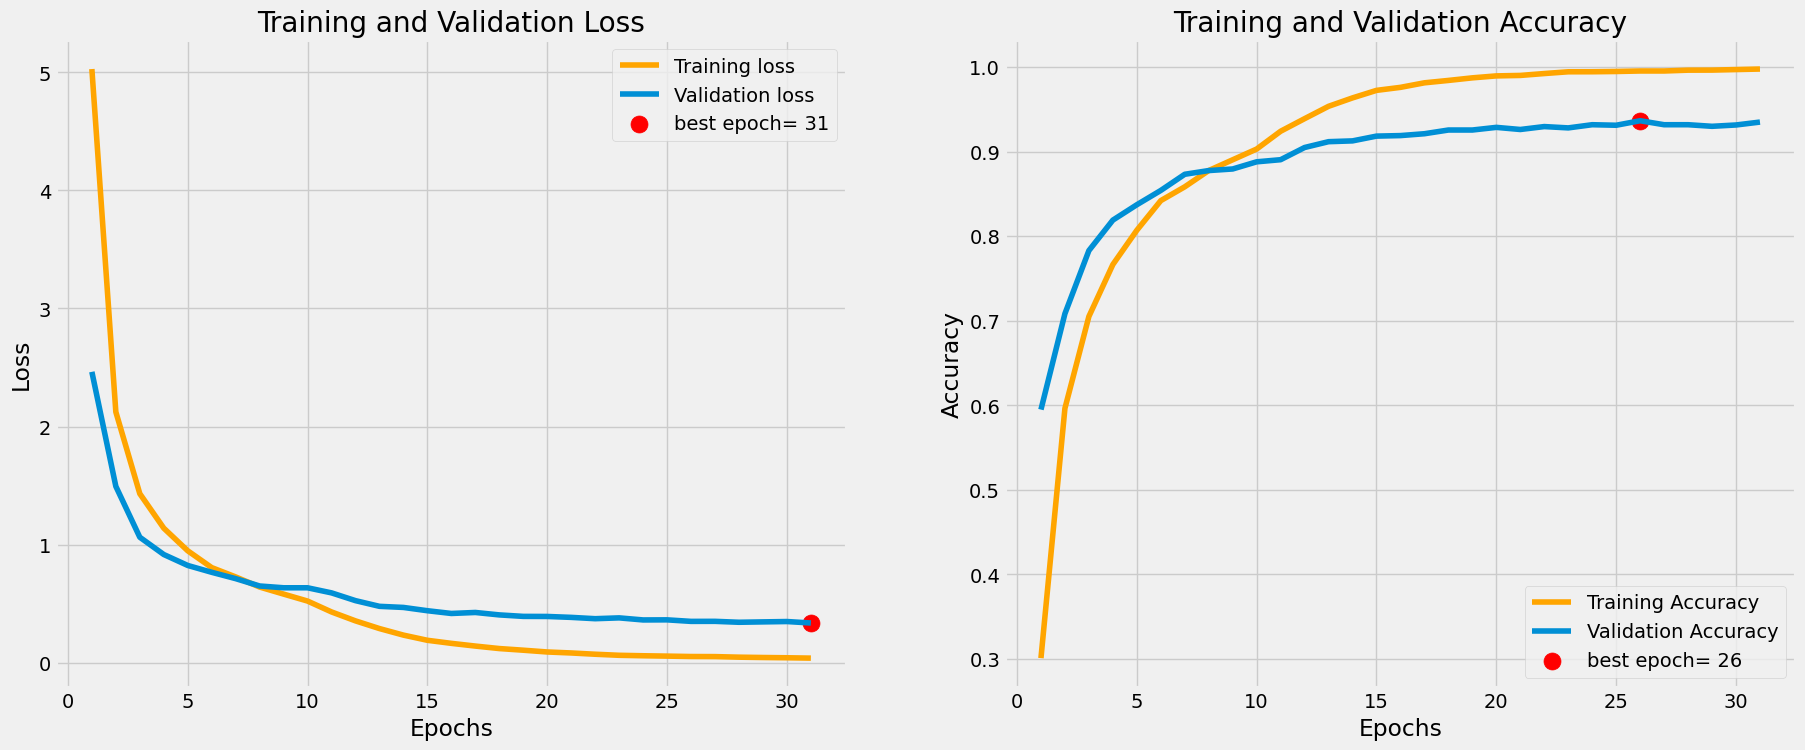

In [31]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [32]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
valid_score = model.evaluate(val_gen)

pd.DataFrame({
    '': ['Loss','Accuracy'],
    'Train score': [train_score[0], f'{round(train_score[1] * 100, 2)}%'],
    'Valid score': [valid_score[0], f'{round(valid_score[1] * 100, 2)}%'],
    'Test score': [test_score[0], f'{round(test_score[1] * 100, 2)}%']})

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 167s 105ms/step - accuracy: 0.9995 - loss: 0.0328
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9364 - loss: 0.3475
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.9314 - loss: 0.3740


,,Train score,Valid score,Test score
0,Loss,0.033099,0.349915,0.33773
1,Accuracy,99.93%,93.64%,93.89%


In [82]:
model = load_model('results_efficientnetv2s/best_model.keras')

def plot_predictions_from_generator(generator, model, num_images = 16):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    class_indices = generator.class_indices
    class_indices = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [class_indices[k] for k in predicted_labels]
    true_labels = [class_indices[k] for k in true_labels]
    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        image = images[i] / 255
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        title = f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}'
        plt.title(title)
        plt.axis('off') 
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


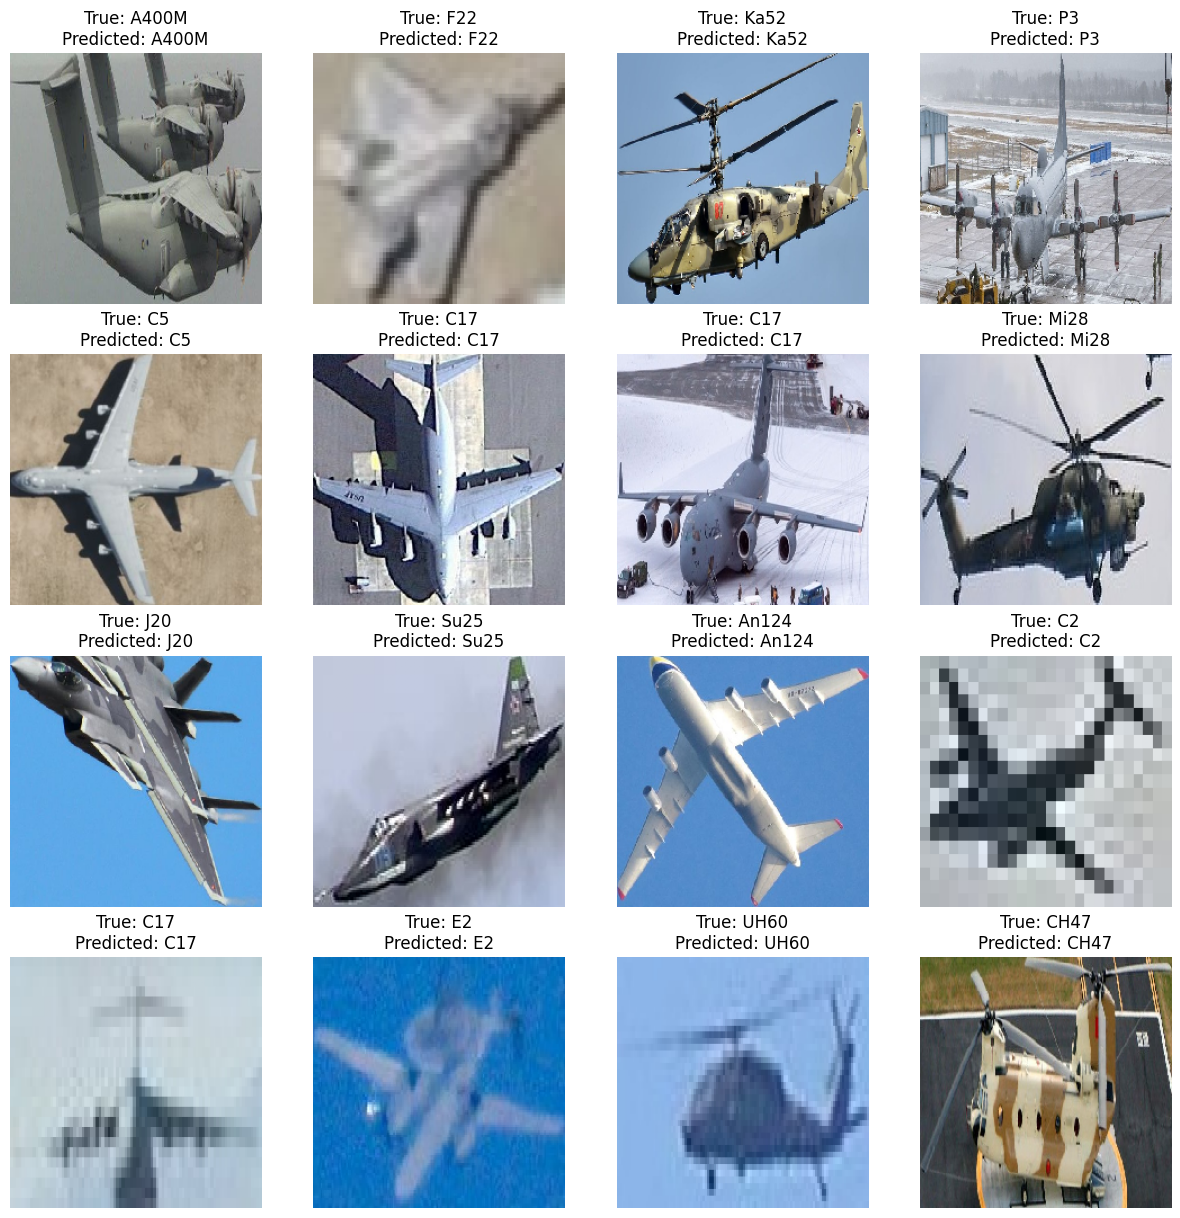

In [83]:
plot_predictions_from_generator(test_gen, model)

In [88]:
# Plot predictions from single picture
def plot_predictions_from_image_in_dataset(image_path, model):
    true_label = image_path.split('/')[-2]

    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_label = np.argmax(predictions)
    # number label to class name
    class_indices = train_gen.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}
    predicted_label = index_to_class[predicted_label]
    plt.imshow(plt.imread(image_path))
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


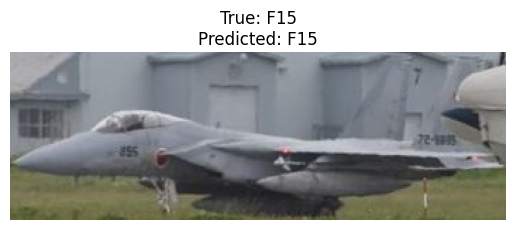

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


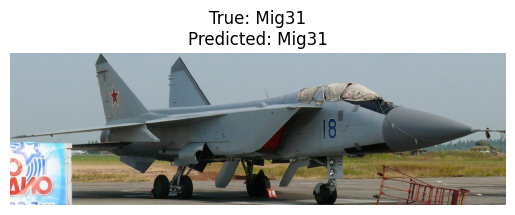

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


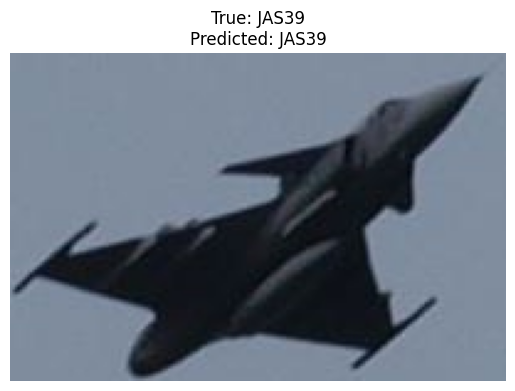

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


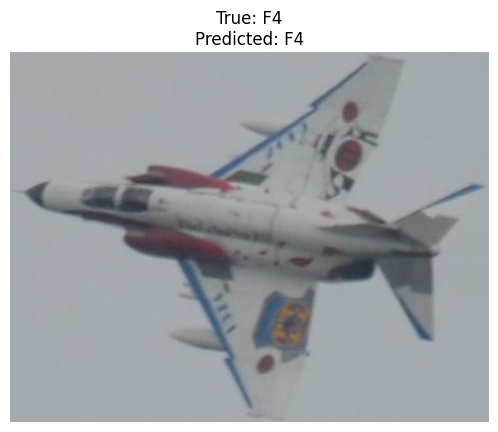

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


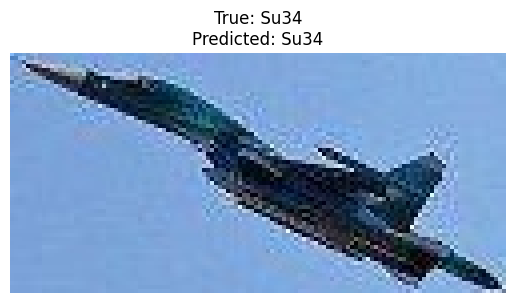

In [90]:
for i in range(5):
    plot_predictions_from_image_in_dataset(test_df['filepaths'].iloc[i], model)